In [1]:
# ---- Parameters ----
SCREEN = "20241118_AWALS35_intermediate_screen_n72"

In [2]:
# Parameters
SCREEN = "20250407_AWALS39_FUS-focused_screen"


In [3]:
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import importlib
import sys
import pandas as pd
from pathlib import Path

sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training
import maps.multiantibody.evaluate as evaluate

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/als/scripts/20250916_pipelines/params")
with open(pdir / "binary-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir / "binary-split-test.json", "r") as f:
    test_params = json.load(f)

train_params["screen"] = SCREEN
test_params["screen"] = SCREEN

dataloader_config = DataLoaderConfig()
train_config = TrainConfig()
model_config = ModelConfig()
model_config.n_classes = 2

antibodies = ["FUS/EEA1"]
response_map = {"WT": 0, "FUS": 1}

In [4]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

assert train_screen.data is not None, "Loading failed"
assert test_screen.data is not None, "Loading failed"

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")

Processing training set...


Preprocessing complete
Processing test set...


Preprocessing complete
Marker set: FUS/EEA1
Train data: (21950, 314)
Test data: (73999, 314)


In [5]:
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader

dataloader_config = DataLoaderConfig()
dataloader_config.batch_size = 8
dataloader_config.n_cells = 250
dataloader_config.response_map = {"Mutations": response_map}

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=train_dataloader._get_scalers(),
    **vars(dataloader_config)
)

In [6]:
importlib.reload(training)
importlib.reload(models)
importlib.reload(evaluate)

eval_model = evaluate.eval
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config.n_epochs = 100
train_config.patience = 10
train_config.lr = 5e-3
train_config.use_contrastive_loss = True

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()
model_config.d_model = 16
model_config.n_layers = 1

model_train = MultiAntibodyClassifier(**vars(model_config))
train(model_train, train_dataloader, train_config)

print("Evaluating model...")
test_dataloader.mode = "eval"
df_test, emb_test = eval_model(model_train, test_dataloader)

model_test = MultiAntibodyClassifier(**vars(model_config))
test_dataloader.mode = "train"
train(model_test, test_dataloader, train_config)

print("Evaluating model...")
train_dataloader.mode = "eval"
df_train, emb_train = eval_model(model_test, train_dataloader)

Starting cell-level training...


Cell Epoch 1/100, Overall Loss: 2.7199, Active: 1/1
  FUS/EEA1 - Loss: 0.7573, Acc: 0.4855 


Cell Epoch 2/100, Overall Loss: 2.3236, Active: 1/1
  FUS/EEA1 - Loss: 0.6096, Acc: 0.6685 


Cell Epoch 3/100, Overall Loss: 2.4107, Active: 1/1
  FUS/EEA1 - Loss: 0.6320, Acc: 0.6550 


Cell Epoch 4/100, Overall Loss: 2.2125, Active: 1/1
  FUS/EEA1 - Loss: 0.6033, Acc: 0.6825 


Cell Epoch 5/100, Overall Loss: 2.1186, Active: 1/1
  FUS/EEA1 - Loss: 0.5140, Acc: 0.7640 


Cell Epoch 6/100, Overall Loss: 2.3300, Active: 1/1
  FUS/EEA1 - Loss: 0.6124, Acc: 0.6670 


Cell Epoch 7/100, Overall Loss: 2.3134, Active: 1/1
  FUS/EEA1 - Loss: 0.5847, Acc: 0.6735 


Cell Epoch 8/100, Overall Loss: 2.3072, Active: 1/1
  FUS/EEA1 - Loss: 0.5931, Acc: 0.6860 


Cell Epoch 9/100, Overall Loss: 2.1273, Active: 1/1
  FUS/EEA1 - Loss: 0.5881, Acc: 0.6830 


Cell Epoch 10/100, Overall Loss: 2.2544, Active: 1/1
  FUS/EEA1 - Loss: 0.6117, Acc: 0.6390 


Cell Epoch 11/100, Overall Loss: 2.0914, Active: 1/1
  FUS/EEA1 - Loss: 0.5884, Acc: 0.6795 


Cell Epoch 12/100, Overall Loss: 2.2519, Active: 1/1
  FUS/EEA1 - Loss: 0.5686, Acc: 0.6955 


Cell Epoch 13/100, Overall Loss: 2.3625, Active: 1/1
  FUS/EEA1 - Loss: 0.6774, Acc: 0.5990 


Cell Epoch 14/100, Overall Loss: 2.1228, Active: 1/1
  FUS/EEA1 - Loss: 0.5709, Acc: 0.7030 


  Freezing FUS/EEA1 encoder at epoch 15
Cell Epoch 15/100, Overall Loss: 2.2222, Active: 0/1
  FUS/EEA1 - Loss: 0.5521, Acc: 0.7190 [FROZEN]
All antibodies frozen - stopping cell training at epoch 15
Starting line-level training...
Unfreezing all antibody encoders for line training...


Line Epoch 1/100, Loss: 1.0728


Line Epoch 2/100, Loss: 0.9259


Line Epoch 3/100, Loss: 1.0370


Line Epoch 4/100, Loss: 0.8114


Line Epoch 5/100, Loss: 0.6595


Line Epoch 6/100, Loss: 0.7985


Line Epoch 7/100, Loss: 0.8488


Line Epoch 8/100, Loss: 0.6859


Line Epoch 9/100, Loss: 0.7248


Line Epoch 10/100, Loss: 0.6766


Line Epoch 11/100, Loss: 0.7872


Line Epoch 12/100, Loss: 0.5870


Line Epoch 13/100, Loss: 0.6450


Line Epoch 14/100, Loss: 0.7432


Line Epoch 15/100, Loss: 0.5996


Line Epoch 16/100, Loss: 0.7219


Line Epoch 17/100, Loss: 0.5726


Line Epoch 18/100, Loss: 0.6221


Line Epoch 19/100, Loss: 0.6291


Line Epoch 20/100, Loss: 0.6708


Line Epoch 21/100, Loss: 0.7458


Line Epoch 22/100, Loss: 0.6286


Line Epoch 23/100, Loss: 0.5529


Line Epoch 24/100, Loss: 0.7279


Line Epoch 25/100, Loss: 0.4250


Line Epoch 26/100, Loss: 0.5314


Line Epoch 27/100, Loss: 0.6822


Line Epoch 28/100, Loss: 0.6694


Line Epoch 29/100, Loss: 0.5213


Line Epoch 30/100, Loss: 0.5715


Line Epoch 31/100, Loss: 0.5507


Line Epoch 32/100, Loss: 0.5694


Line Epoch 33/100, Loss: 0.6226


Line Epoch 34/100, Loss: 0.5748


Line Epoch 35/100, Loss: 0.5560
Early stopping line training at epoch 35
Training completed!
Evaluating model...


Starting cell-level training...


Cell Epoch 1/100, Overall Loss: 2.6451, Active: 1/1
  FUS/EEA1 - Loss: 0.6877, Acc: 0.5813 


Cell Epoch 2/100, Overall Loss: 2.4845, Active: 1/1
  FUS/EEA1 - Loss: 0.6413, Acc: 0.6410 


Cell Epoch 3/100, Overall Loss: 2.3757, Active: 1/1
  FUS/EEA1 - Loss: 0.5879, Acc: 0.7008 


Cell Epoch 4/100, Overall Loss: 2.3647, Active: 1/1
  FUS/EEA1 - Loss: 0.5790, Acc: 0.7116 


Cell Epoch 5/100, Overall Loss: 2.3123, Active: 1/1
  FUS/EEA1 - Loss: 0.5782, Acc: 0.7088 


Cell Epoch 6/100, Overall Loss: 2.3182, Active: 1/1
  FUS/EEA1 - Loss: 0.5979, Acc: 0.6838 


Cell Epoch 7/100, Overall Loss: 2.4536, Active: 1/1
  FUS/EEA1 - Loss: 0.6425, Acc: 0.6393 


Cell Epoch 8/100, Overall Loss: 2.3078, Active: 1/1
  FUS/EEA1 - Loss: 0.5872, Acc: 0.6896 


Cell Epoch 9/100, Overall Loss: 2.2553, Active: 1/1
  FUS/EEA1 - Loss: 0.5715, Acc: 0.7115 


Cell Epoch 10/100, Overall Loss: 2.2633, Active: 1/1
  FUS/EEA1 - Loss: 0.5788, Acc: 0.6988 


Cell Epoch 11/100, Overall Loss: 2.2225, Active: 1/1
  FUS/EEA1 - Loss: 0.5574, Acc: 0.7200 


Cell Epoch 12/100, Overall Loss: 2.3034, Active: 1/1
  FUS/EEA1 - Loss: 0.6010, Acc: 0.6753 


Cell Epoch 13/100, Overall Loss: 2.2672, Active: 1/1
  FUS/EEA1 - Loss: 0.5826, Acc: 0.6886 


Cell Epoch 14/100, Overall Loss: 2.1808, Active: 1/1
  FUS/EEA1 - Loss: 0.5548, Acc: 0.7139 


Cell Epoch 15/100, Overall Loss: 2.3408, Active: 1/1
  FUS/EEA1 - Loss: 0.6417, Acc: 0.6335 


Cell Epoch 16/100, Overall Loss: 2.1824, Active: 1/1
  FUS/EEA1 - Loss: 0.5671, Acc: 0.7034 


Cell Epoch 17/100, Overall Loss: 2.3115, Active: 1/1
  FUS/EEA1 - Loss: 0.6163, Acc: 0.6616 


Cell Epoch 18/100, Overall Loss: 2.1704, Active: 1/1
  FUS/EEA1 - Loss: 0.5647, Acc: 0.7035 


Cell Epoch 19/100, Overall Loss: 2.1375, Active: 1/1
  FUS/EEA1 - Loss: 0.5723, Acc: 0.7040 


Cell Epoch 20/100, Overall Loss: 2.2148, Active: 1/1
  FUS/EEA1 - Loss: 0.5669, Acc: 0.7064 


Cell Epoch 21/100, Overall Loss: 2.1600, Active: 1/1
  FUS/EEA1 - Loss: 0.5552, Acc: 0.7174 


Cell Epoch 22/100, Overall Loss: 2.2409, Active: 1/1
  FUS/EEA1 - Loss: 0.6101, Acc: 0.6764 


Cell Epoch 23/100, Overall Loss: 2.3149, Active: 1/1
  FUS/EEA1 - Loss: 0.6179, Acc: 0.6569 


  Freezing FUS/EEA1 encoder at epoch 24
Cell Epoch 24/100, Overall Loss: 2.1508, Active: 0/1
  FUS/EEA1 - Loss: 0.5939, Acc: 0.6815 [FROZEN]
All antibodies frozen - stopping cell training at epoch 24
Starting line-level training...
Unfreezing all antibody encoders for line training...


Line Epoch 1/100, Loss: 0.5582


Line Epoch 2/100, Loss: 0.4922


Line Epoch 3/100, Loss: 0.4325


Line Epoch 4/100, Loss: 0.3003


Line Epoch 5/100, Loss: 0.4658


Line Epoch 6/100, Loss: 0.3522


Line Epoch 7/100, Loss: 0.3705


Line Epoch 8/100, Loss: 0.3016


Line Epoch 9/100, Loss: 0.2503


Line Epoch 10/100, Loss: 0.3508


Line Epoch 11/100, Loss: 0.2839


Line Epoch 12/100, Loss: 0.4827


Line Epoch 13/100, Loss: 0.3633


Line Epoch 14/100, Loss: 0.4234


Line Epoch 15/100, Loss: 0.2704


Line Epoch 16/100, Loss: 0.3091


Line Epoch 17/100, Loss: 0.2764


Line Epoch 18/100, Loss: 0.2885


Line Epoch 19/100, Loss: 0.3331
Early stopping line training at epoch 19
Training completed!
Evaluating model...


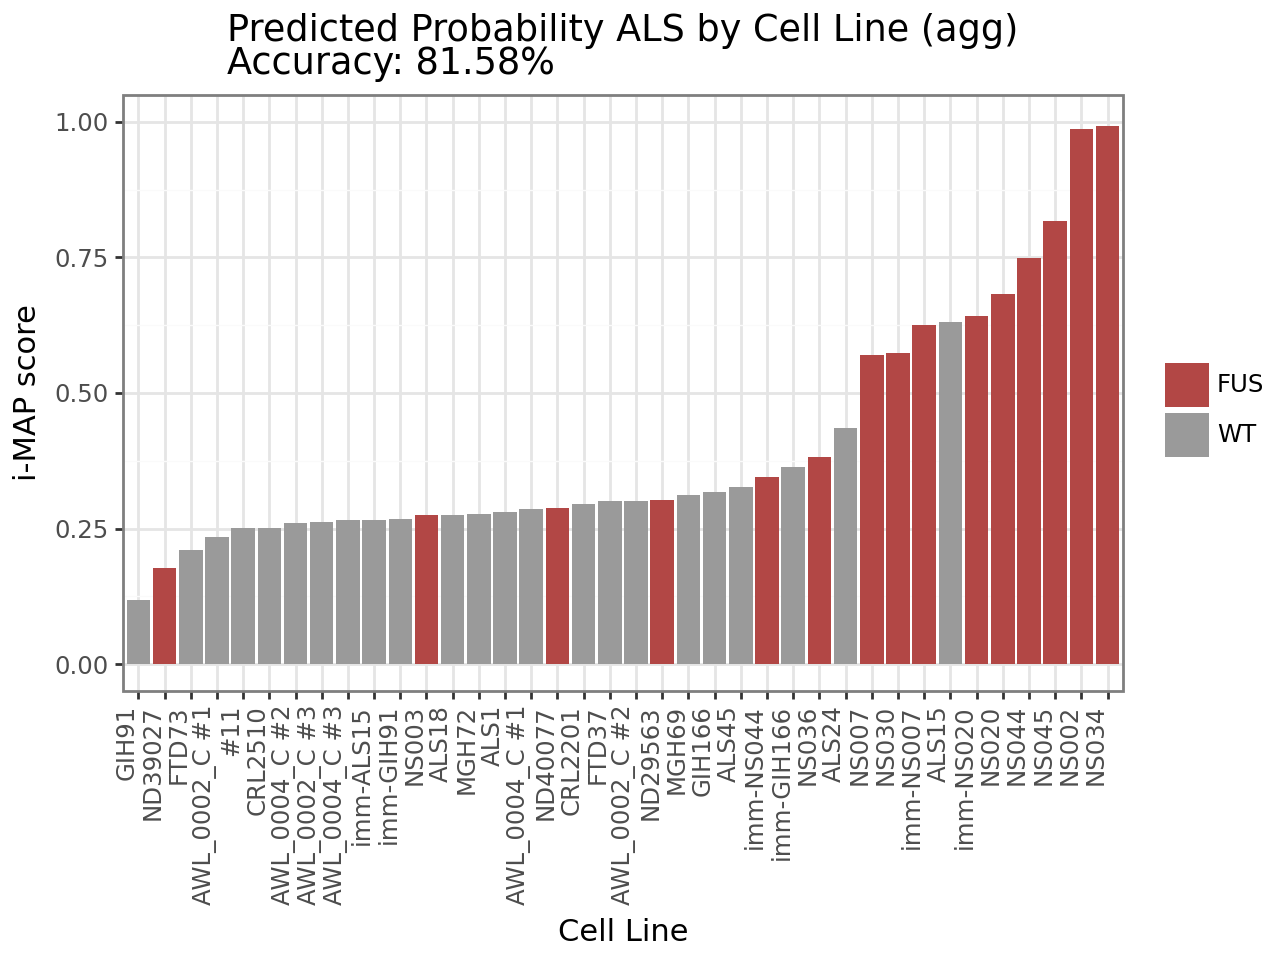

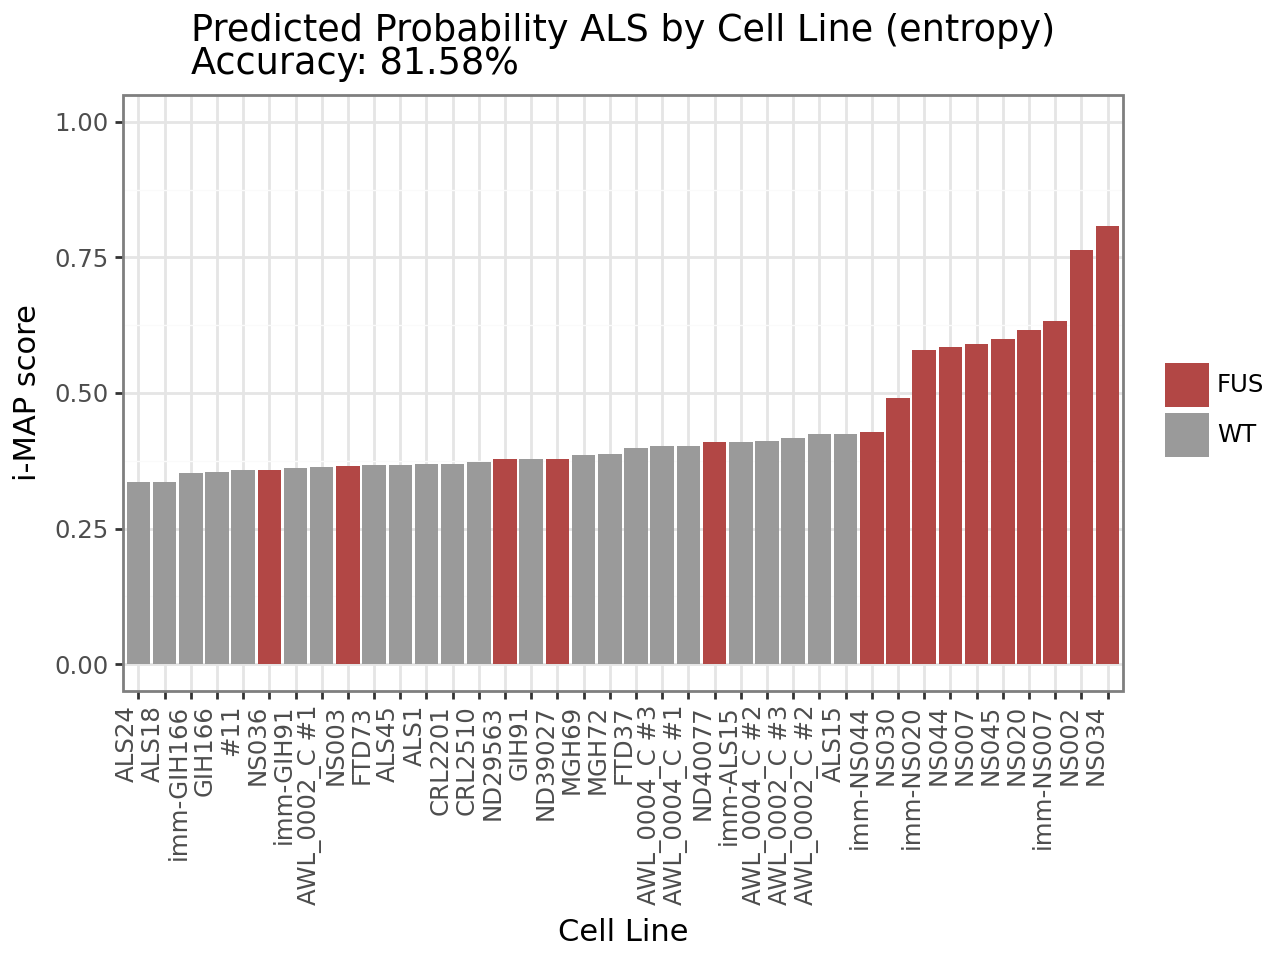

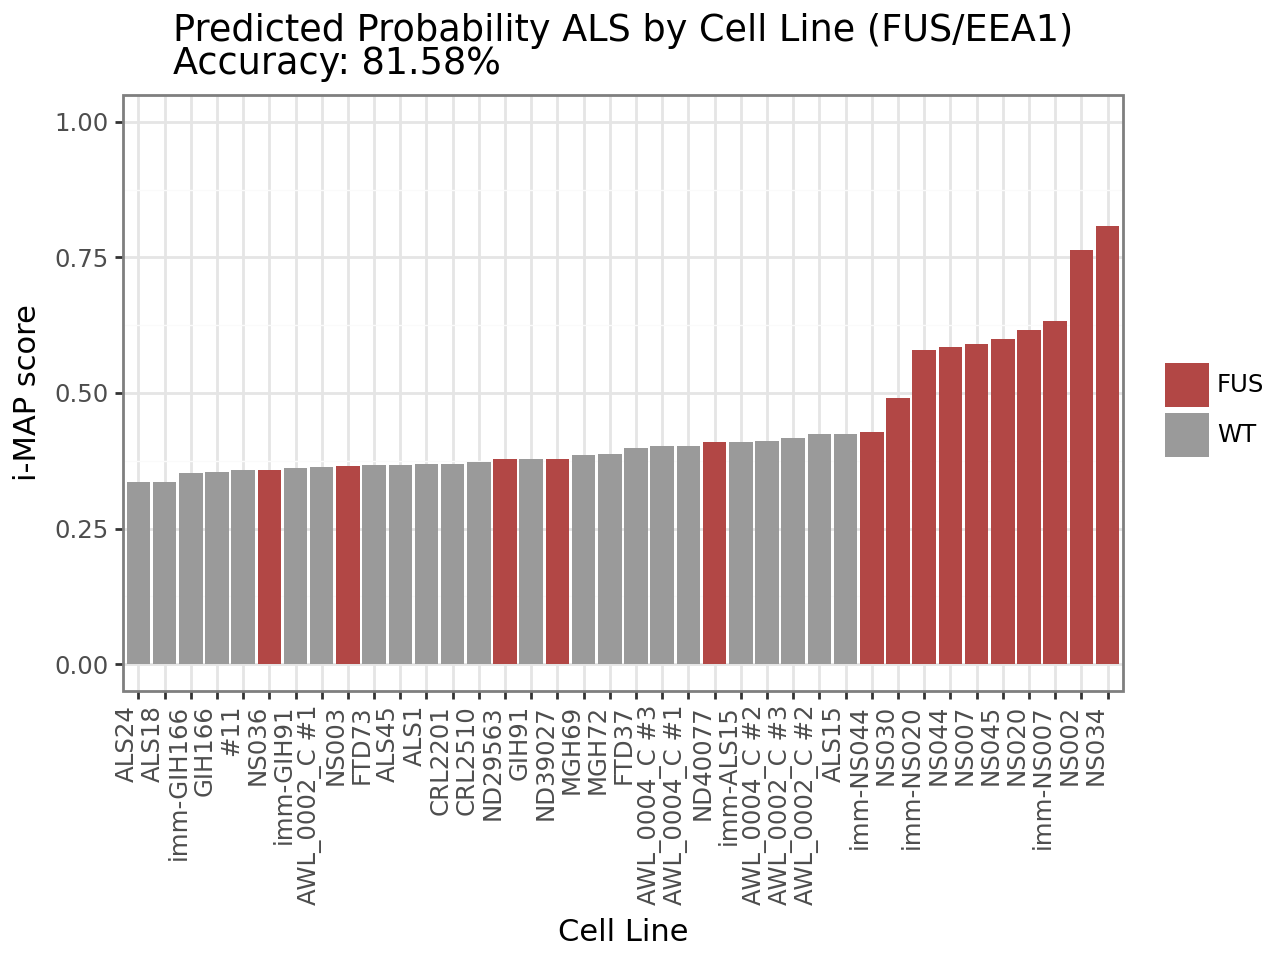

In [7]:
from IPython.display import display
from maps.figures import PALETTE

from plotnine import (
    ggplot, aes, geom_bar, theme, element_text, labs, ggtitle, scale_fill_manual, ylim, theme_bw
)

df = pd.concat([df_train, df_test])
groups = ["agg", "entropy"] + antibodies

def plot_preds(df, groups, response_map):
    for g in groups:
        # Sort preds by predicted probability (Class_1) in ascending order
        preds = df.sort_values(by=f'class_1_{g}', ascending=True)
        
        preds['CellLines'] = pd.Categorical(
            preds['CellLines'], categories=preds['CellLines'], ordered=True
        )
        
        # Compute prediction accuracy for current group
        pred_labels = (preds[f'class_1_{g}'] > 0.5)
        accuracy = (pred_labels == preds["True"]).mean()
        preds["True"] = preds["True"].map({0: "WT", 1: "FUS"})
        
        p = (
            ggplot(preds, aes(x='CellLines', y=f'class_1_{g}', fill='True')) +
            geom_bar(stat='identity') +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=90, hjust=1)) +
            labs(x='Cell Line', y='i-MAP score', fill="") +
            ggtitle(
                f"Predicted Probability ALS by Cell Line ({g})\nAccuracy: {accuracy:.2%}") +
            scale_fill_manual(values=PALETTE) +
            ylim(0, 1)
        )
        display(p)
        
plot_preds(df, groups, response_map)

In [8]:

screen = train_params["screen"]
df["Mutation"] = df["True"].map({0: "WT", 1: "FUS"})
df = df.rename(columns={"True": "TrueClass"})
df = df.rename(columns={"class_0_agg":"prob_0", "class_1_agg":"prob_1"})
df = df[["prob_0", "prob_1", "CellLines", "TrueClass", "Mutation"]]

out_dir = Path("/home/kkumbier/als/analysis_results")
out_path = out_dir / SCREEN / f"fus_v_wt.csv"
df.to_csv(out_path, index=False)